In [1]:
import pandas as pd

In [2]:
df_ncc = pd.read_csv("./ncc.binetflow")
df_ncc=df_ncc[~df_ncc['Label'].str.contains("Background", case=False, na=False)]
df_ncc = df_ncc.sample(25000)
df_iot = pd.read_csv("./iot23.csv").sample(25000)
df_ctu = pd.read_csv("./ctu.csv").sample(25000)
df_ctu=df_ctu[~df_ctu['Label'].str.contains("Background", case=False, na=False)]
df_ctu = df_ctu.sample(25000)

C:\Users\tejas\AppData\Local\Temp\ipykernel_16172\157375421.py:1: DtypeWarning: Columns (1,9,10,11,12,13,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ncc = pd.read_csv("./ncc.binetflow")
C:\Users\tejas\AppData\Local\Temp\ipykernel_16172\157375421.py:4: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_iot = pd.read_csv("./iot23.csv").sample(25000)
C:\Users\tejas\AppData\Local\Temp\ipykernel_16172\157375421.py:5: DtypeWarning: Columns (5,8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ctu = pd.read_csv("./ctu.csv").sample(25000)


In [3]:
df_iot['ActivityLabel'] = df_iot['label'].apply(lambda x: 0 if x == 'Benign' else 1)
df_iot = df_iot.drop(columns=['label'])
df_ctu['ActivityLabel'] = df_ctu['BOTNET'].apply(lambda x: 0 if x == 0 else 1)
df_ctu = df_ctu.drop(columns=['BOTNET'])

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from time import time

In [5]:
def calculate_additional_graph_metrics(G):
    # Calculate in-degree and out-degree
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())

    # Calculate eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

    # Calculate betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)

    return in_degree, out_degree, eigenvector_centrality, betweenness_centrality


def convert_categorical_to_numeric(df):
    le = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':
            df[column] = le.fit_transform(df[column])
    return df

def convert_categorical_to_numeric(df):
    le = LabelEncoder()
    encoding_maps = {}
    for column in df.columns:
        if column == 'SrcAddr' or column == 'DstAddr':
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = le.fit_transform(df[column])
                encoding_maps[column] = dict(zip(le.transform(le.classes_), le.classes_))
        else:
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = df[column].astype(str)
                df[column] = le.fit_transform(df[column])
    return df, encoding_maps

In [6]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

def feature_selection_vif(dataset, srcLabel, dstLabel, alpha=0.005, vif_threshold=20):
    # Load and clean the dataset
    df = dataset
    df = df.drop_duplicates()
    df = df.dropna()
    
    df['ActivityLabel'] = df['ActivityLabel'].apply(lambda x: 0 if x == 0 else 1)

    # Convert non-numeric features to numeric
    df, maps = convert_categorical_to_numeric(df)
    
    # Create the graph from IPs
    ips = df[[srcLabel, dstLabel]]
    G = nx.DiGraph()
    for _, row in ips.iterrows():
        G.add_edge(row[srcLabel], row[dstLabel])

    # Calculate centrality metrics
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
    in_degree_centrality = dict(G.in_degree())
    out_degree_centrality = dict(G.out_degree())

    def refined_normalize(metric):
        values = np.array(list(metric.values()))
        if len(values) == 0 or values.max() == values.min():
            return dict(zip(metric.keys(), values))
        percentiles = np.percentile(values, np.linspace(0, 100, 101))
        normalized_values = np.interp(values, percentiles, np.linspace(0, 1, 101))
        return dict(zip(metric.keys(), normalized_values))

    degree_centrality_norm = refined_normalize(degree_centrality)
    closeness_centrality_norm = refined_normalize(closeness_centrality)
    betweenness_centrality_norm = refined_normalize(betweenness_centrality)
    eigenvector_centrality_norm = refined_normalize(eigenvector_centrality)
    in_degree_centrality_norm = refined_normalize(in_degree_centrality)
    out_degree_centrality_norm = refined_normalize(out_degree_centrality)

    # Compute Composite Node Importance (CNI)
    cni_scores = {}
    for node in G.nodes():
        cni_scores[node] = (degree_centrality_norm.get(node, 0) +
                            closeness_centrality_norm.get(node, 0) +
                            betweenness_centrality_norm.get(node, 0)) / 3

    # Add CNI scores and other metrics to the dataset
    dataset_with_metrics = df.copy()
    dataset_with_metrics['orig_h_CNI'] = dataset_with_metrics[srcLabel].map(cni_scores)
    dataset_with_metrics['resp_h_CNI'] = dataset_with_metrics[dstLabel].map(cni_scores)
    dataset_with_metrics['average_CNI'] = dataset_with_metrics[['orig_h_CNI', 'resp_h_CNI']].mean(axis=1)

    dataset_with_metrics['orig_degree'] = dataset_with_metrics[srcLabel].map(degree_centrality_norm)
    dataset_with_metrics['resp_degree'] = dataset_with_metrics[dstLabel].map(degree_centrality_norm)
    dataset_with_metrics['orig_closeness'] = dataset_with_metrics[srcLabel].map(closeness_centrality_norm)
    dataset_with_metrics['resp_closeness'] = dataset_with_metrics[dstLabel].map(closeness_centrality_norm)
    dataset_with_metrics['orig_betweenness'] = dataset_with_metrics[srcLabel].map(betweenness_centrality_norm)
    dataset_with_metrics['resp_betweenness'] = dataset_with_metrics[dstLabel].map(betweenness_centrality_norm)
    dataset_with_metrics['orig_eigenvector'] = dataset_with_metrics[srcLabel].map(eigenvector_centrality_norm)
    dataset_with_metrics['resp_eigenvector'] = dataset_with_metrics[dstLabel].map(eigenvector_centrality_norm)
    dataset_with_metrics['orig_in_degree'] = dataset_with_metrics[srcLabel].map(in_degree_centrality_norm)
    dataset_with_metrics['resp_in_degree'] = dataset_with_metrics[dstLabel].map(in_degree_centrality_norm)
    dataset_with_metrics['orig_out_degree'] = dataset_with_metrics[srcLabel].map(out_degree_centrality_norm)
    dataset_with_metrics['resp_out_degree'] = dataset_with_metrics[dstLabel].map(out_degree_centrality_norm)

    # Separate features for VIF calculation
    df_final = dataset_with_metrics.drop(["orig_h_CNI", "resp_h_CNI"], axis=1)
    
    # Calculate traditional VIF
    def calculate_vif(df):
        X = df.values
        vif_scores = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        vif_data = pd.DataFrame({'Feature': df.columns, 'Traditional_VIF': vif_scores})
        return vif_data
    start_time_1 = time()
    vif_results = calculate_vif(df_final)
    vif_time = time() - start_time_1
    
    vif_scores = vif_results

    # Iterative VIF-based feature selection
    features_to_remove = []
    high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()
    while high_vif_features:
        feature_to_remove = high_vif_features[0]
        features_to_remove.append(feature_to_remove)
        vif_results = vif_results[vif_results['Feature'] != feature_to_remove]
        remaining_features = vif_results['Feature'].tolist()
        X_subset = df_final[remaining_features]
        vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
        high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()

    # Calculate Modified VIF
    def calculate_modified_vif(X, alpha):
        features = X.columns
        
        feat_list = features.tolist()
        feat_list.remove("average_CNI")
        features = pd.Index(feat_list)
        mvif_data = []
        for feature in features:
            predictors = [feat for feat in features if feat != feature]
            model = LinearRegression().fit(X[predictors], X[feature])
            r_squared = model.score(X[predictors], X[feature])
            average_cni_mean = dataset_with_metrics['average_CNI'].mean()
            # Normalizing the adjustment term
            normalized_adjustment = (r_squared + alpha * average_cni_mean) / (1 + alpha * average_cni_mean)
        
        # Ensure the value inside the division is positive
            if normalized_adjustment >= 1.0:
                normalized_adjustment = 1.0 - 1e-6  # Adjust to avoid negative or zero denominator

            modified_vif = 1 / (1 - normalized_adjustment)
            mvif_data.append({'Feature': feature, 'Modified_VIF': modified_vif})
        
        return pd.DataFrame(mvif_data)
    
            

    X = df_final
    start_time_1 = time()
    mvif_results = calculate_modified_vif(X, alpha)
    mvif_time = time() - start_time_1

    # Normalize MVIF values
    mvif_values = mvif_results['Modified_VIF'].values
    mvif_min, mvif_max = mvif_values.min(), mvif_values.max()
    mvif_results['Normalized_Modified_VIF'] = (mvif_values - mvif_min) / (mvif_max - mvif_min)

    final_vif_results = pd.merge(vif_scores, mvif_results, on='Feature')
    selected_features = mvif_results[mvif_results['Modified_VIF'] < vif_threshold]['Feature'].tolist()

    return df_final, final_vif_results,mvif_time,vif_time


In [7]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import numpy as np

def apply_pca_rfe_and_compare(df, final_vif_results, label_col='ActivityLabel', vif_threshold=10):
    selected_features_vif = final_vif_results[final_vif_results['Traditional_VIF'] < vif_threshold]['Feature'].tolist()
    selected_features_mvif = final_vif_results[final_vif_results['Modified_VIF'] < vif_threshold]['Feature'].tolist()
    X_vif = df[selected_features_vif]
    X_mvif = df[selected_features_mvif]
    y = df[label_col]

    # Apply PCA
    start_time = time()
    pca = PCA(n_components=0.95)  # Retain 95% of variance
    X_pca = pca.fit_transform(df.drop(columns=[label_col]))
    pca_time = time() - start_time

    # Get PCA loadings and select top features
    pca_loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=df.drop(columns=[label_col]).columns)
    pca_selected_features = pca_loadings.abs().mean(axis=1).nlargest(10).index.tolist()  # Select top 10 features

    # Apply RFE
    start_time = time()
    model = LogisticRegression(solver='liblinear')
    rfe = RFE(model, n_features_to_select=10)
    rfe.fit(df.drop(columns=[label_col]), y)
    rfe_selected_features = df.drop(columns=[label_col]).columns[rfe.support_].tolist()
    rfe_time = time() - start_time

    # Compile the results
    result = {
        'VIF': selected_features_vif,
        'CNI-VIF': selected_features_mvif,
        'PCA': pca_selected_features,
        'RFE': rfe_selected_features
    }

    # Return results and times
    return result, pca_time, rfe_time

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.utils import to_categorical

def create_ffnn(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
    
    # Ensure the input length is sufficient for pooling
    if input_shape[0] >= 2:
        model.add(MaxPooling1D(2))
    
    conv1_output_length = input_shape[0] - 2  # Since kernel size is 3
    pool1_output_length = conv1_output_length // 2

    # Check if the length is sufficient for another Conv1D and MaxPooling1D layer
    if pool1_output_length >= 3:
        model.add(Conv1D(64, 3, activation='relu'))
        if pool1_output_length >= 6:  # Ensure the length is sufficient after another pooling
            model.add(MaxPooling1D(2))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def evaluate_models(selection_result, df, label_col='ActivityLabel'):
    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear'),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True),
        'Ensemble (Voting)': VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(solver='liblinear')),
                ('rf', RandomForestClassifier()),
                ('svm', SVC(probability=True))
            ], voting='soft'
        )
    }
    
    results = {technique: {} for technique in selection_result.keys()}
    
    for technique, features in selection_result.items():
        X = df[features]
        y = df[label_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for model_name, model in models.items():
            start_time = time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            computation_time = time() - start_time
            
            results[technique][model_name] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'Computation Time': computation_time
            }
        
        start_time = time()
        ffnn = create_ffnn(X_train.shape[1])
        ffnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred_ffnn = (ffnn.predict(X_test) > 0.5).astype(int).flatten()
        accuracy_ffnn = accuracy_score(y_test, y_pred_ffnn)
        precision_ffnn = precision_score(y_test, y_pred_ffnn)
        recall_ffnn = recall_score(y_test, y_pred_ffnn)
        f1_ffnn = f1_score(y_test, y_pred_ffnn)
        computation_time_ffnn = time() - start_time
        
        results[technique]['FFNN'] = {
            'Accuracy': accuracy_ffnn,
            'Precision': precision_ffnn,
            'Recall': recall_ffnn,
            'F1-Score': f1_ffnn,
            'Computation Time': computation_time_ffnn
        }
        
        start_time = time()
        X_train_cnn = np.expand_dims(X_train, axis=2)
        X_test_cnn = np.expand_dims(X_test, axis=2)
        input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])
        cnn = create_cnn(input_shape)
        cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred_cnn = (cnn.predict(X_test_cnn) > 0.5).astype(int).flatten()
        accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
        precision_cnn = precision_score(y_test, y_pred_cnn)
        recall_cnn = recall_score(y_test, y_pred_cnn)
        f1_cnn = f1_score(y_test, y_pred_cnn)
        computation_time_cnn = time() - start_time
        
        results[technique]['CNN'] = {
            'Accuracy': accuracy_cnn,
            'Precision': precision_cnn,
            'Recall': recall_cnn,
            'F1-Score': f1_cnn,
            'Computation Time': computation_time_cnn
        }
    
    return results

def plot_results(results, title):
    plot_data = []
    for technique, metrics in results.items():
        for model_name, result in metrics.items():
            plot_data.append({
                'Technique': technique,
                'Model': model_name,
                'Accuracy': result['Accuracy'],
                'Precision': result['Precision'],
                'Recall': result['Recall'],
                'F1-Score': result['F1-Score'],
                'Computation Time': result['Computation Time']
            })
    plot_df = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Technique', y='Accuracy', hue='Model', data=plot_df)
    plt.title(f'Model Accuracy by Feature Selection Technique for {title}')
    plt.ylabel('Accuracy')
    plt.xlabel('Feature Selection Technique')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Technique', y='Precision', hue='Model', data=plot_df)
    plt.title(f'Model Precision by Feature Selection Technique for {title}')
    plt.ylabel('Precision')
    plt.xlabel('Feature Selection Technique')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Technique', y='Recall', hue='Model', data=plot_df)
    plt.title(f'Model Recall by Feature Selection Technique for {title}')
    plt.ylabel('Recall')
    plt.xlabel('Feature Selection Technique')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Technique', y='F1-Score', hue='Model', data=plot_df)
    plt.title(f'Model F1-Score by Feature Selection Technique for {title}')
    plt.ylabel('F1-Score')
    plt.xlabel('Feature Selection Technique')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Technique', y='Computation Time', hue='Model', data=plot_df)
    plt.title(f'Model Computation Time by Feature Selection Technique for {title}')
    plt.ylabel('Computation Time (seconds)')
    plt.xlabel('Feature Selection Technique')
    plt.legend(loc='best')
    plt.show()

def extract_data(data):
    result = []
    for feature_selection in data:
        for model, metrics in data[feature_selection].items():
            result.append([
                feature_selection,
                model,
                metrics['Accuracy'],
                metrics['Precision'],
                metrics['Recall'],
                metrics['F1-Score'],
                metrics['Computation Time']
            ])
    return result

def create_table(data):
    df = pd.DataFrame(data, columns=[
        'Feature Selection Technique',
        'Model',
        'Accuracy',
        'Precision',
        'Recall',
        'F1-Score',
        'Computation Time'
    ])
    return df

def plot_times(times,dataset_label):
    algorithms = ['VIF', 'CNI-VIF', 'PCA', 'RFE']
    plt.figure(figsize=(10, 6))
    plt.plot(algorithms, times, marker='o', linestyle='-', color='b')
    plt.xlabel('Algorithm')
    plt.ylabel('Time (seconds)')
    plt.title(f'Algorithm Execution Times for {dataset_label}')
    plt.grid(True)
    plt.show()


In [18]:
def final_output(df,src_label,dst_label,dataset_name):
    df_final,vif_comparison_table,mvif_time,vif_time = feature_selection_vif(df,src_label,dst_label)
    print(vif_comparison_table)

    selection_result,pca_time,rfe_time = apply_pca_rfe_and_compare(df_final, vif_comparison_table)
    print(selection_result)

    plot_times([vif_time,mvif_time,pca_time,rfe_time],dataset_name)
    print(f"PCA:{pca_time} RFE:{rfe_time} MVIF:{mvif_time} VIF:{vif_time}")

    model_results = evaluate_models(selection_result, df_final)
    plot_results(model_results,dataset_name)
    extracted_data = extract_data(model_results)
    table = create_table(extracted_data)
    return table

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\tejas\AppData\Local\Temp\ipykernel_16172\1891372090.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

             Feature  Traditional_VIF   Modified_VIF  Normalized_Modified_VIF
0          StartTime     4.029316e+00       1.034696             0.000000e+00
1                Dur     6.941688e+00       2.018937             9.842413e-07
2              Proto     6.566209e+01       7.411835             6.377146e-06
3            SrcAddr     5.658851e+01      11.876982             1.084230e-05
4              Sport     3.991462e+00       2.142080             1.107385e-06
5                Dir     1.035370e+01       7.834000             6.799311e-06
6            DstAddr     4.628092e+00       1.555657             5.209616e-07
7              Dport     3.025482e+01       1.631024             5.963280e-07
8              State     4.268922e+00       1.961240             9.265448e-07
9               sTos              NaN  999999.999971             1.000000e+00
10              dTos              NaN  999999.999971             1.000000e+00
11           TotPkts     3.792859e+00       1.245686            

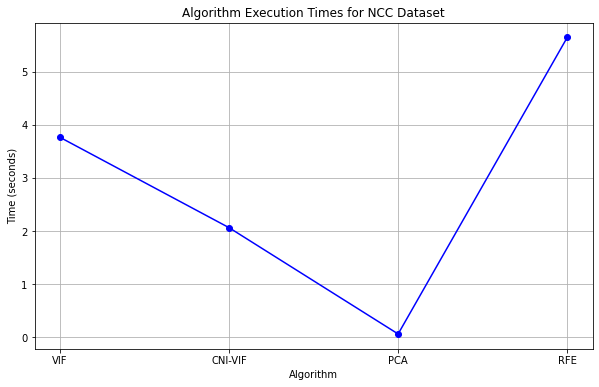

PCA:0.06562161445617676 RFE:5.641740560531616 MVIF:2.064976692199707 VIF:3.7640490531921387
201/201 [==============================] - 1s 2ms/step


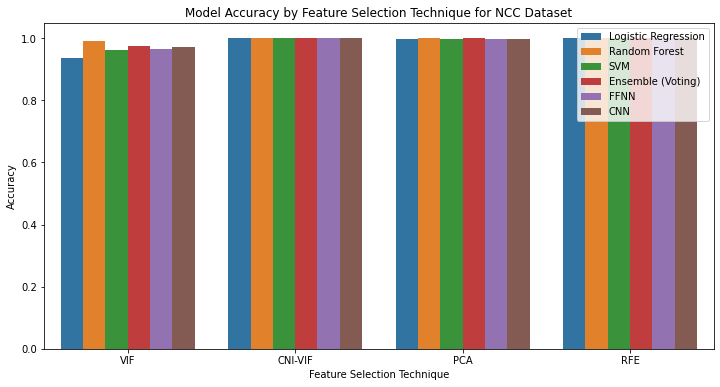

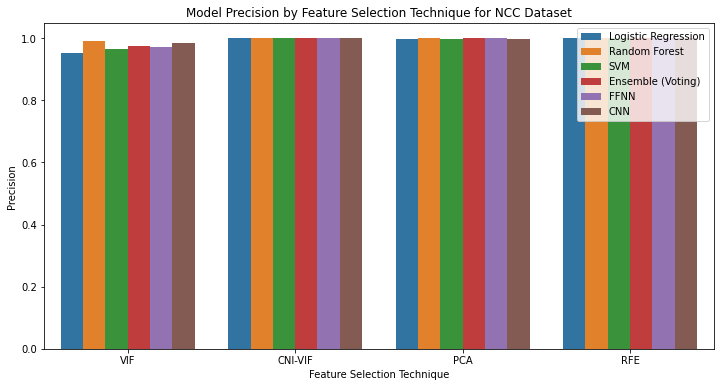

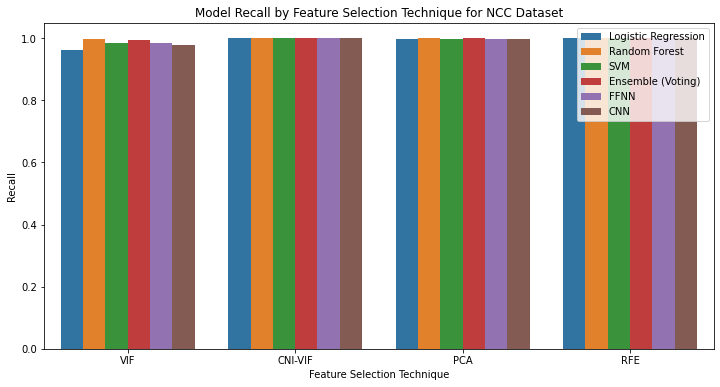

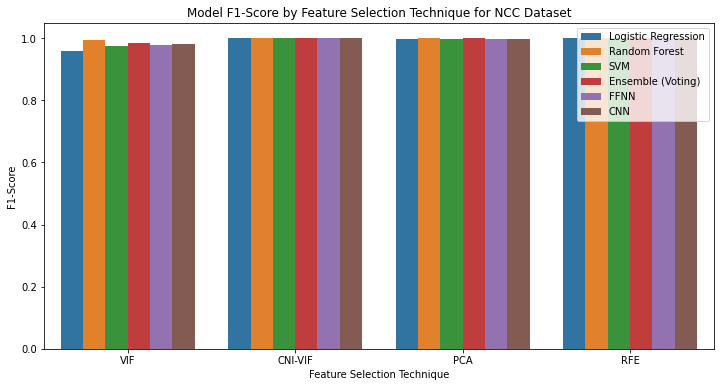

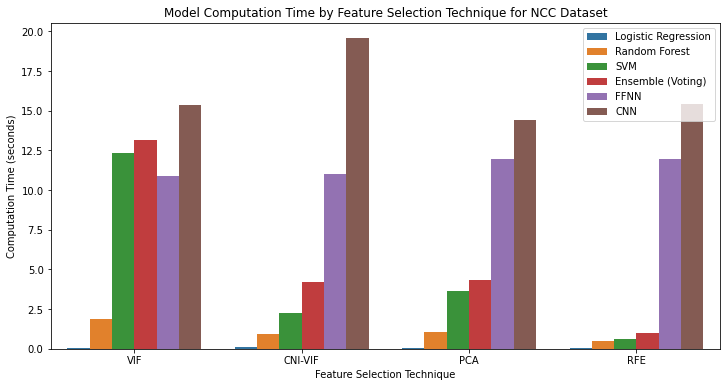

,Feature Selection Technique,Model,Accuracy,Precision,Recall,F1-Score,Computation Time
0,VIF,Logistic Regression,0.934952,0.952840,0.962888,0.957837,0.033011
1,VIF,Random Forest,0.990663,0.991325,0.996552,0.993932,1.861297
2,VIF,SVM,0.962652,0.966210,0.985804,0.975908,12.361887
3,VIF,Ensemble (Voting),0.974012,0.973559,0.993105,0.983235,13.183465
4,VIF,FFNN,0.965297,0.971366,0.983776,0.977531,10.864903
5,VIF,CNN,0.972144,0.985691,0.977895,0.981777,15.371153
6,CNI-VIF,Logistic Regression,0.999844,1.000000,0.999797,0.999899,0.084917
7,CNI-VIF,Random Forest,0.999844,1.000000,0.999797,0.999899,0.945146
8,CNI-VIF,SVM,0.999844,1.000000,0.999797,0.999899,2.254641
9,CNI-VIF,Ensemble (Voting),0.999844,1.000000,0.999797,0.999899,4.221322


In [20]:
table0 = final_output(df_ncc,"SrcAddr","DstAddr","NCC Dataset")
table0

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: 

             Feature  Traditional_VIF   Modified_VIF  Normalized_Modified_VIF
0         Unnamed: 0     1.033303e+00       1.037617             3.244995e-08
1                 ts     1.194050e+01      11.990355             1.098520e-05
2                uid     1.000988e+00       1.005167             0.000000e+00
3          id.orig_h     3.443254e+00       3.457631             2.452467e-06
4          id.orig_p     1.560239e+00       1.566754             5.615871e-07
5          id.resp_h     1.095911e+00       1.100487             9.531980e-08
6          id.resp_p     2.200734e+00       2.209923             1.204757e-06
7              proto     3.327921e+00       3.341817             2.336652e-06
8            service     2.436569e+00       2.446743             1.441578e-06
9           duration     1.875172e+00       1.883002             8.778357e-07
10        orig_bytes     4.447212e+00       4.465781             3.460617e-06
11        resp_bytes     3.347829e+00       3.361808            

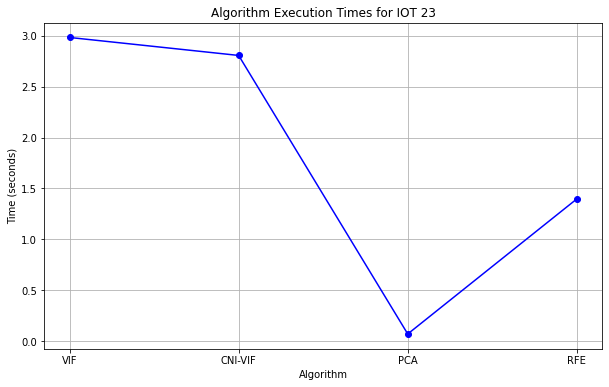

PCA:0.07078361511230469 RFE:1.396934986114502 MVIF:2.8059298992156982 VIF:2.982454538345337
235/235 [==============================] - 1s 2ms/step


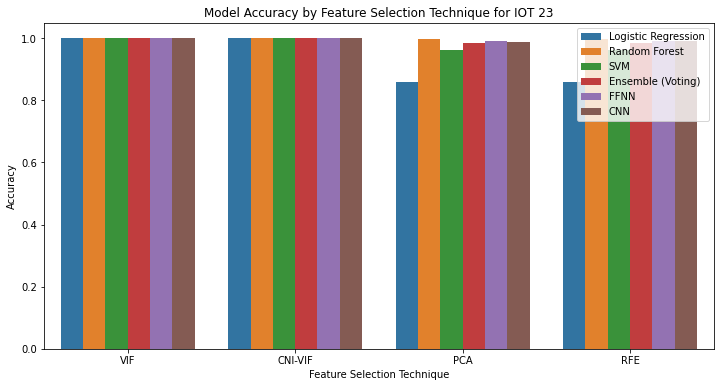

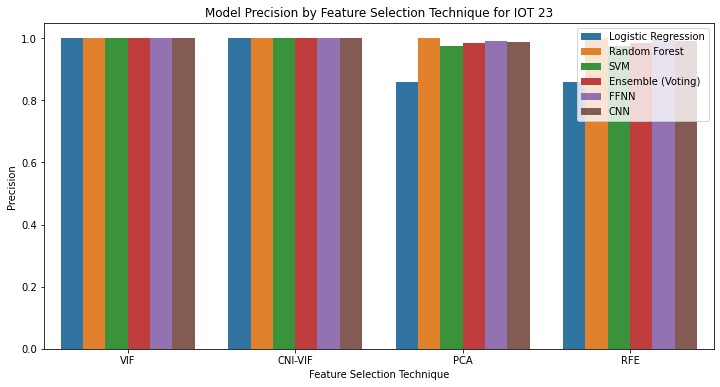

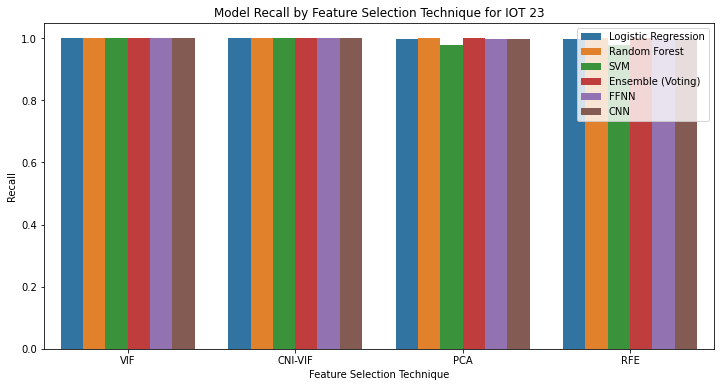

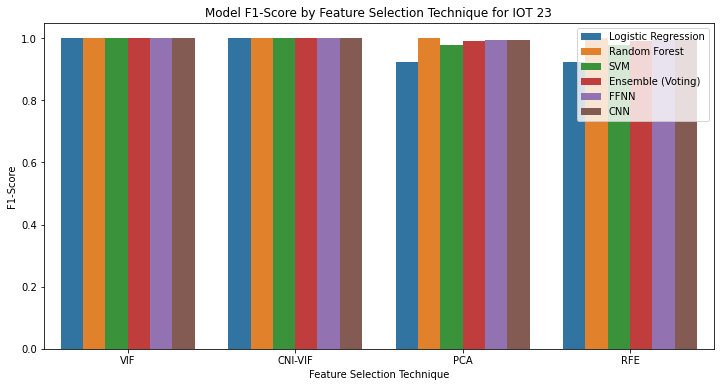

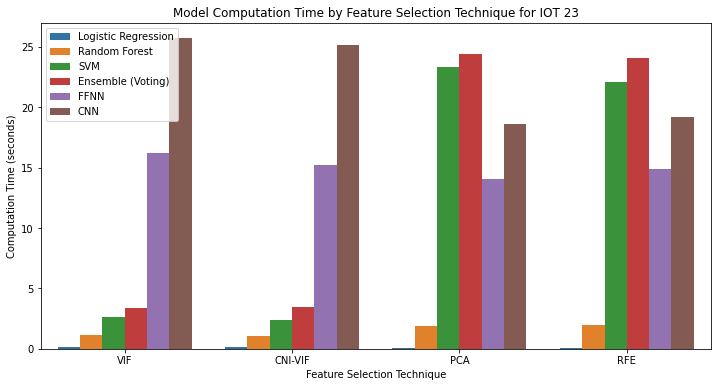

,Feature Selection Technique,Model,Accuracy,Precision,Recall,F1-Score,Computation Time
0,VIF,Logistic Regression,1.000000,1.000000,1.000000,1.000000,0.118948
1,VIF,Random Forest,1.000000,1.000000,1.000000,1.000000,1.142629
2,VIF,SVM,0.999867,1.000000,0.999845,0.999922,2.593075
3,VIF,Ensemble (Voting),1.000000,1.000000,1.000000,1.000000,3.408846
4,VIF,FFNN,1.000000,1.000000,1.000000,1.000000,16.191792
5,VIF,CNN,1.000000,1.000000,1.000000,1.000000,25.717150
6,CNI-VIF,Logistic Regression,1.000000,1.000000,1.000000,1.000000,0.121133
7,CNI-VIF,Random Forest,1.000000,1.000000,1.000000,1.000000,1.046106
8,CNI-VIF,SVM,0.999600,1.000000,0.999534,0.999767,2.366647
9,CNI-VIF,Ensemble (Voting),1.000000,1.000000,1.000000,1.000000,3.500832


In [21]:
table1 = final_output(df_iot,"id.orig_h","id.resp_h","IOT 23")
table1

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\tejas\AppData\Local\Temp\ipykernel_16172\1891372090.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

             Feature  Traditional_VIF   Modified_VIF  Normalized_Modified_VIF
0       Unnamed: 0.1              inf  999999.999971             1.000000e+00
1         Unnamed: 0              inf  999999.999971             1.000000e+00
2                Dur     1.610552e+00       1.593184             5.383694e-07
3              Proto     2.570839e+02      71.481831             7.042709e-05
4            SrcAddr     2.459281e+01       4.957330             3.902519e-06
5              Sport     4.927826e+00       2.291836             1.237022e-06
6                Dir     2.365831e+02      65.845618             6.479087e-05
7            DstAddr     3.772237e+00       2.568625             1.513811e-06
8              Dport     1.117146e+02       1.701515             6.466998e-07
9              State     2.766807e+00       2.296000             1.241186e-06
10              sTos              NaN  999999.999971             1.000000e+00
11              dTos              NaN  999999.999971            

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

{'VIF': ['Dur', 'Sport', 'DstAddr', 'State', 'SrcBytes', 'ActivityLabel', 'resp_eigenvector'], 'CNI-VIF': ['Dur', 'SrcAddr', 'Sport', 'DstAddr', 'Dport', 'State', 'SrcBytes', 'Label', 'StartTime', 'ActivityLabel', 'orig_degree', 'orig_betweenness', 'resp_betweenness', 'orig_eigenvector', 'resp_eigenvector', 'orig_in_degree', 'orig_out_degree'], 'PCA': ['TotBytes', 'Unnamed: 0.1', 'Unnamed: 0', 'SrcBytes', 'StartTime', 'TotPkts', 'Sport', 'Dur', 'Label', 'DstAddr'], 'RFE': ['orig_degree', 'resp_degree', 'orig_closeness', 'resp_closeness', 'orig_betweenness', 'resp_betweenness', 'orig_eigenvector', 'resp_in_degree', 'orig_out_degree', 'resp_out_degree']}


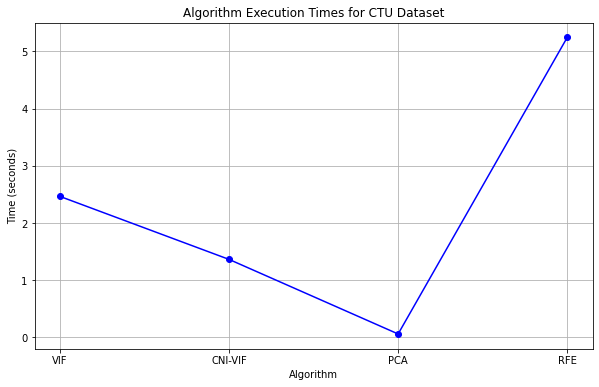

PCA:0.0586855411529541 RFE:5.244417428970337 MVIF:1.3629708290100098 VIF:2.464627742767334
96/96 [==============================] - 0s 2ms/step


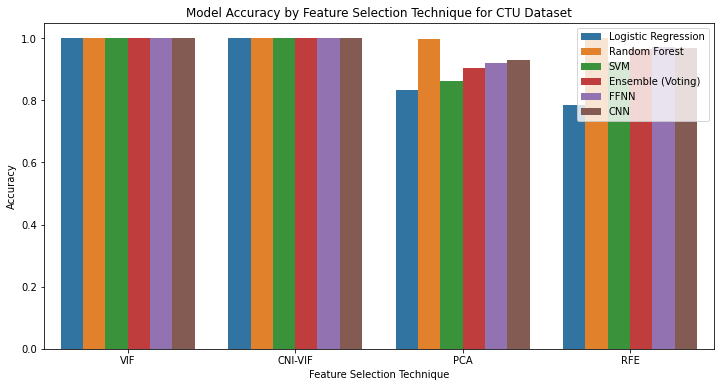

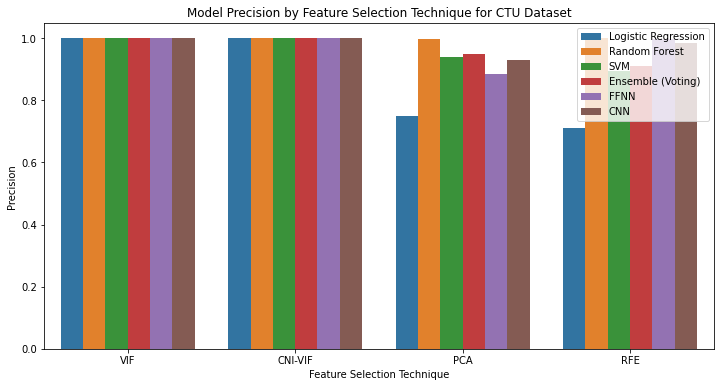

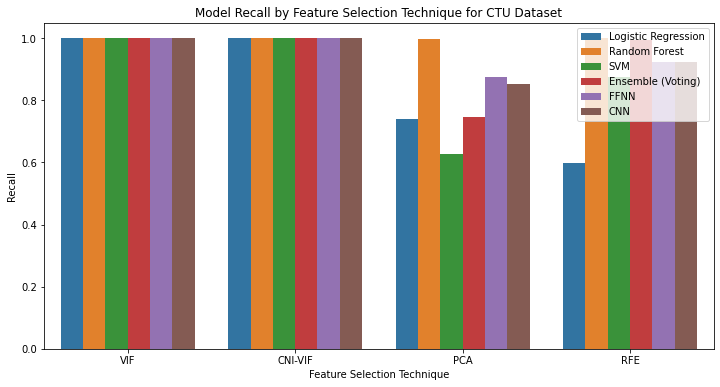

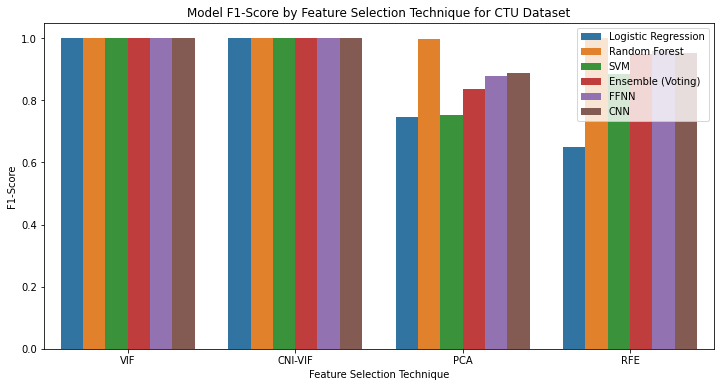

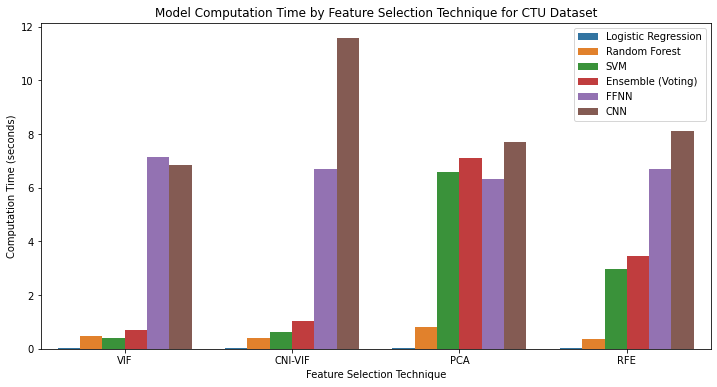

,Feature Selection Technique,Model,Accuracy,Precision,Recall,F1-Score,Computation Time
0,VIF,Logistic Regression,1.000000,1.000000,1.000000,1.000000,0.019769
1,VIF,Random Forest,1.000000,1.000000,1.000000,1.000000,0.460183
2,VIF,SVM,1.000000,1.000000,1.000000,1.000000,0.406695
3,VIF,Ensemble (Voting),1.000000,1.000000,1.000000,1.000000,0.689386
4,VIF,FFNN,1.000000,1.000000,1.000000,1.000000,7.126951
5,VIF,CNN,1.000000,1.000000,1.000000,1.000000,6.857141
6,CNI-VIF,Logistic Regression,1.000000,1.000000,1.000000,1.000000,0.024514
7,CNI-VIF,Random Forest,1.000000,1.000000,1.000000,1.000000,0.391156
8,CNI-VIF,SVM,1.000000,1.000000,1.000000,1.000000,0.609788
9,CNI-VIF,Ensemble (Voting),1.000000,1.000000,1.000000,1.000000,1.049808


In [19]:
table2 = final_output(df_ctu,"SrcAddr","DstAddr","CTU Dataset")
table2